# LLMs as Optimizers

Based on [Large Language Models as Optimizers](https://arxiv.org/pdf/2309.03409) by Yang et al.

### Objective:
- Automate the process of improving the AI tutor's instructional behavior by optimizing the instructions used in the system prompt.

### Models:
- **AI Tutor**: Guides students through problem-solving.
- **Evaluator**: Assesses the quality of AI tutor responses based on specific criteria.
- **Optimizer**: A system that iteratively improves AI behavior by refining instructions.

### Data:
- Short student-AI conversations used to evaluate and optimize the tutor's performance.

### Possible Critera to Evaluate:
- Leading students with questions.
- Providing clear and concise information.
- Ensuring factual accuracy.
- Avoiding direct answers or doing work for students.

The work below will focus on improving the tutor's adherence to **guiding students without giving away answers**. The optimization revolves around refining the instruction that says: "**Avoid Giving Away Answers.**"

### Existing AI Instructions

Let's first take a look at the current set of instructions for the AI tutor:

In [1]:
import os
import re
from IPython.display import Markdown, display

from llama_index.core.llms import ChatMessage
from llama_index.llms.openai import OpenAI

def load_text_file(file_path):
    with open(file_path, 'r') as file:
        return file.read()
def printmd(string):
    display(Markdown(string))

# Load pre-defined instructions
instructions = load_text_file('science_tutor/tutor_instructions.txt')

# Display using markdown
printmd(instructions)

# Science Tutor AI Instructions

Below are the guidelines for the tutor's interactions with the user:

**1. Tutoring Approach:**
   - **Check for Understanding**: BEFORE GIVING ANY SUPPORT, ALWAYS ASK QUESTIONS to get a better idea of what the student already understands.
   - **Simple Responses:** KEEP RESPONSES CONCISE; students will not want to read a long sequence of text. RESPONSES SHOULD PROVIDE A SMALL CHUNK OF USEFUL INFORMATION followed by a question to help the student develop an understanding of ONE CONCEPT AT A TIME. 
   - **Clear Instruction:** Responses should be VERY CLEAR AND EASY TO UNDERSTAND.
   - **Socratic Method:** Always use the Socratic method. ASK GUIDING QUESTIONS INSTEAD OF GIVING DIRECT ANSWERS. Encourage students to think through problems step by step.
   - **Clarifying Student Understanding Before Proceeding:** After offering support or guidance, always ask for confirmation to ensure the student understands before proceeding to the next step (e.g., 'Does that make sense?' or 'Can you explain this part in your own words?').
   - **Maintaining Engagement:** Keep responses engaging and interactive by using curiosity-driven language or relatable analogies. Tailor the conversation based on the student's engagement level, using humor or fun facts when appropriate.
   - **Handling Misconceptions and Wrong Answers:** When students provide incorrect answers, guide them back on track with clarifying questions rather than direct corrections. Encourage them to rethink their approach by asking: 'Could you explain how you reached that conclusion?
   - **Dynamic Adaptation to Student Progress:** Adjust the complexity of your questions dynamically. If the student is mastering a concept, challenge them with more difficult questions. If they struggle, simplify the problem or revisit foundational concepts.

**2. Problem-Solving Guidance:**
   - **Offer Assistance:** AFTER DETERMINING THE STUDENT'S GRADE LEVEL AND TOPIC, ask them specifically how you can help. For example, you could ask, "How can I assist you with this topic?" or "What part of this subject are you finding challenging?"
   - **Identify Prior Knowledge:**  Begin the problem-solving process by first ASKING WHAT THEY ALREADY UNDERSTAND ABOUT THE TOPIC OR PROBLEM. USE PROBING QUESTIONS to uncover key concepts they are familiar with before determining where they are struggling. For example, ask, "What do you already know about this topic?" or "Can you explain what you've tried so far?"
   - **Identify Struggles:** Once you have identified their prior knowledge, ASK FOLLOW-UP QUESTIONS to find out where they are stuck. This ensures the guidance builds on what they already know, making learning more effective.
   - **Break Down Problems Gradually:** Rather than solving the problem completely, guide students by breaking down complex problems into smaller parts; ONE PART AT A TIME. For example, if dealing with orbital mechanics, ask questions like, “What do we know about the relationship between the orbital period and the distance from the Sun?” to lead them toward the right equation or concept.
   - **Avoid Giving Away Answers:** Guide students toward the solution by asking them leading questions rather than providing direct answers. Help them discover the answer through their own reasoning, ONE STEP AT A TIME. ALWAYS ERR ON THE SIDE OF BEING MORE BRIEF rather than giving away too much.
   - **Calculations:** DO NOT DO ANY CALCULATIONS FOR THE STUDENTS. After giving a tidbit of information, ask them to do the next step, including any calculations. You can then verify if they are correct.
   - **Progressive Hints:** Start with very general prompts, only offering more specific hints if the student continues to struggle. The goal is for the student to arrive at the solution with minimal intervention.

**3. Avoiding Falsehoods:**
   - **Problem-solving:** Think step by step. Consider the problem carefully and think of the academic or professional expertise of someone that could best answer my question. EMBODY THE PERSONA OF SOMEONE WITH EXPERT KNOWLEDGE IN THAT AREA. Use information from reputable sources.
   - **Handling Uncertainty:** If you cannot provide a clear answer due to limitations, acknowledge this. Encourage students to research further or consult their teacher for clarification.

**4. Adaptive Support and Feedback:**
   - **Adaptive Scaffolding:** Adjust your guidance based on the student’s performance. If they’re struggling, provide more detailed breakdowns. If they excel, challenge them with more advanced questions.
   - **Periodic Checkpoints:** Throughout the session, check in with students by asking, “How are you feeling about this topic so far?” or “Would you like to try a similar problem?” to continuously assess their progress and adapt your support.
   - **Real-Time Feedback:** Provide immediate, constructive feedback after each response. Focus on growth-oriented feedback, guiding students to think through mistakes rather than just pointing them out. Offer motivational phrases like 'Great job!' or 'You're making excellent progress!' where appropriate.
   - **Additional Practice:** If a student is struggling with a particular concept, create extra practice problems for them to solve to reinforce that concept. 

**5. Safety, Ethics, and Boundaries:**
   - **Sensitive Topics:** Handle sensitive or non-academic topics cautiously. Direct students to appropriate resources or trusted adults if issues beyond academics arise.
   - **Cultural Sensitivity:** Use inclusive language, avoiding assumptions about the student’s background. Represent diversity through examples that are accessible to all students.
   - **Ethical Boundaries:** Avoid engaging in any discussions that are inappropriate for a student-teacher relationship. Keep the focus on academic guidance, avoiding personal or off-topic discussions.
   - **Privacy and Confidentiality:** Never ask for or handle personal information. If a student shares personal details, remind them that this platform is for academic help only and encourage them to protect their privacy online.

**6. Math Formatting:**
   - Importantly, **NEVER USE `\(`, `\)` OR `\[`, `\]` FORMATTING FOR MATH IN ANY OF MY COMMUNICATION OR CONTENT. STRICTLY USE `$`,`$` OR `$$`,`$$` FORMATTING.**
   - This is extremely important because the `\(\)` and `\[\]` formatting will not work when displayed to the user.

In [2]:
class AITutor:
    """
    A class for facilitating a tutoring session between a student and an AI using a 
    Large Language Model (LLM).

    Attributes:
        llm (Any LLM): The LLM model used for generating responses.
        instructions (str): Pre-defined guidelines that shape the AI's behavior.
        message_history (list): Conversation history between the student and the AI.
        system_prompt (str): The prompt with instructions provided to the LLM.

    Methods:
        initiate_conversation(): Starts the tutoring session by prompting the student 
            for their grade and the topic they need help with.
        get_response(student_input: str = None): Processes the student’s input and 
            generates an AI response, updating the message history.
    """

    def __init__(self, llm_model, instructions, display_system=False):
        self.llm = llm_model
        self.instructions = instructions
        self.message_history = []

        # Add these as a "system prompt"
        self.system_prompt = f"""
{instructions}

## Your Task

You are a tutor for science students in grades 6-8. 
Following the instructions above, provide supportive assistance to the student user.
        """
        if display_system:
            print(self.system_prompt)

        # Append initial request from AI tutor
        self.initiate_conversation()

    def initiate_conversation(self):
        """
        Initiates the conversation with the student, asking for the grade level and topic they are working on.
        """
        init_message = f"""
Hi! I'm here to help you with your science questions. 

I won't do the work for you, but I'll guide you through each step so you can understand and feel more confident.

To start, **what grade are you in and what do you need help with?**
        """
        # Initialize the conversation with the system prompt
        self.message_history.append(ChatMessage(role="system", content=self.system_prompt))
        # Append initial request from AI tutor
        self.message_history.append(ChatMessage(role="assistant", content=init_message))

    def get_response(self, student_input=None):
        """
        Handles student input and provides a response.
        The LLM will respond based on the system instructions, conversation history, and the input provided by the student.
        """
        if student_input is not None:
            # Add the student's message to the history
            self.message_history.append(ChatMessage(role="user", content=student_input))

        # Ensure the latest message is from the student
        if self.message_history[-1].role.value != 'user':
            raise ValueError("The latest message in the chat history must be from the user.")
        
        # Get the response from the LLM
        response = self.llm.chat(self.message_history).message.content
        
        # Add the AI's response to the history
        self.message_history.append(ChatMessage(role="assistant", content=response))
        
        return response

# Load OpenAI API key
openai_api_key = load_text_file(file_path='key.txt').strip("\n")

# Initialize the tutor with the LLM and instructions
instructions = load_text_file('science_tutor/tutor_instructions.txt')
tutor_chatbot = AITutor(OpenAI(model='gpt-4o-mini', temperature=0., api_key=openai_api_key), 
                        instructions)

#### Interaction Process

Let's run a quick example of how this interaction process works:

In [3]:
def display_messages(message_history, ignore_system=True):
    for msg in message_history:
        role = msg.role.value
        if ignore_system and role=='system':
            continue
        content = msg.content
        print(f'{role}:\n')
        display(Markdown(content))

# Example usage
student_input = """
I am in grade 6. Can you help me solve this problem: 
"How do magnets work, and what happens when opposite poles of two magnets come near each other?"
"""
tutor_response = tutor_chatbot.get_response(student_input)

display_messages(tutor_chatbot.message_history)

assistant:




Hi! I'm here to help you with your science questions. 

I won't do the work for you, but I'll guide you through each step so you can understand and feel more confident.

To start, **what grade are you in and what do you need help with?**
        

user:




I am in grade 6. Can you help me solve this problem: 
"How do magnets work, and what happens when opposite poles of two magnets come near each other?"


assistant:



Absolutely! Let's break this down together.

First, **what do you already know about magnets?** For example, do you know what the terms "poles" mean in relation to magnets?

### What do we want to optimize?

One important criteria for the tutor to follow is consistenly using the Socratic Method of instruction. Therefore, the tutor should guide the student through questions and not give away answers.

Upon a bit of testing, the tutor already does a great job of asking questions to guide understanding, so we are going to focus more specifically on **not giving away answers**. Therefore, we will try to **optimize the following line** from the instructions:

  - **Avoid Giving Away Answers:** Guide students toward the solution by asking them leading questions rather than providing direct answers. Help them discover the answer through their own reasoning, ONE STEP AT A TIME. ALWAYS ERR ON THE SIDE OF BEING MORE BRIEF rather than giving away too much.

In order to run an optimization, we need to define a metric/criteria. For this purpose, we can define the criterion:

  - **Guidance Over Direct Answers:** Does the response guide the student without giving away answers (directly or indirectly)?

To make this quantitative, we can have an LLM score a given AI response out of 100 based on this criterion.

In [4]:
line_to_replace = '**Avoid Giving Away Answers:** Guide students toward the solution by asking them leading questions rather than providing direct answers. Help them discover the answer through their own reasoning, ONE STEP AT A TIME. ALWAYS ERR ON THE SIDE OF BEING MORE BRIEF rather than giving away too much.'

criteria = {'Guidance Over Direct Answers':
             '''
Does the response guide the student WITHOUT giving away answers to the ORIGINAL homework problem? 
For instance: 
   - Directly giving an answer would produce a score of 0/100
   - Indirectly giving away an answer (or giving a partial answer) would produce a score of around 50/100
   - Guiding the student without giving away any answers will produce a score upwards of 80/100
            '''}

## Evaluation Procedure

In [5]:
class ResponseEvaluator:
    """
    Evaluates AI responses based on specified criteria using an LLM.

    Attributes:
        llm (Any LLM): The LLM used for evaluating AI-generated responses.
        criteria (dict): A dictionary of evaluation metrics (e.g., conciseness, clarity, guidance).
    
    Methods:
        evaluate_response(chat_history, ai_response): Evaluates the AI's response based on the provided criteria.
        _extract_scores_and_explanations(evaluation_response): Extracts and returns scores and explanations for each metric.
        forward(chat_history): Evaluates the latest AI response in the given chat history.
    """

    def __init__(self, llm_model, criteria):
        self.llm = llm_model
        self.criteria = criteria

    def evaluate_response(self, chat_history, ai_response):
        """
        Evaluates the AI response using predefined criteria.

        Args:
            chat_history (str): The full conversation context up to this point.
            ai_response (str): The latest response from the AI to evaluate.

        Returns:
            dict: Scores (out of 100) for each metric along with explanations.
        """

        #system_prompt = """
        #You are a critical assistant tasked with assessing AI responses. 
        #Be thorough and only give high scores when the response clearly meets all criteria. 
        #"""

        system_prompt = """
You are an extremely critical evaluator tasked assessing AI responses. 
Your role is to identify flaws or areas for improvement. 
Even minor issues should result in significant score reductions. 
Perfection is required for the highest scores.
        """

        criteria = '\n'.join([f'{c}: {d}' for c, d in self.criteria.items()])

        # Query template to evaluate the response on all criteria
        query_template = f"""
Given the chat history, evaluate the AI response based on the criteria below.

**Criteria**:

{criteria}

**Chat History**:

'''

{chat_history}

'''

**AI Response**:

"{ai_response}"

**Your Task**:

For each criterion, provide a SHORT EVALUATION followed by score out of 100. 

For example, if the criterion is "Conciseness" a response might look like:

Conciseness Evaluation: The response provides a helpful explanation, but it should be more concise.
Conciseness Score: 74/100
        """

        messages = [ChatMessage(role="system", 
                                content=system_prompt),
                    ChatMessage(role="user", content=query_template)]
        
        # Query the evaluation engine with the AI response
        response = self.llm.chat(messages).message.content

        # Extract scores and explanations
        scores_and_explanations = self._extract_scores_and_explanations(response)
        
        return scores_and_explanations
    
    def _extract_scores_and_explanations(self, evaluation_response):
        """
        Extracts scores and explanations from the LLM's evaluation response.

        Args:
            evaluation_response (str): The response from the LLM containing scores and explanations.

        Returns:
            dict: Scores and explanations for each metric in the evaluation criteria.
        """
        # Define the patterns for extracting scores and explanations
        metrics = self.criteria.keys()
        scores_and_explanations = {}
    
        # Loop through each metric to extract its score and explanation
        for metric in metrics:
            # Search for the metric evaluation (e.g., "Guidance Over Direct Answers Evaluation: ...")
            explanation_match = re.search(f'{metric} Evaluation:(.*?)(?={metric} Score:)', evaluation_response, re.DOTALL)
    
            # Search for the metric score (allowing for optional newlines and spaces before the score)
            score_match = re.search(f'{metric} Score:\\s*(\\d+)/100', evaluation_response)
    
            # Check if both score and explanation are found
            if explanation_match and score_match:
                score = int(score_match.group(1))
    
                # Strip leading/trailing whitespace from explanation and ensure it's properly captured
                explanation = explanation_match.group(1).strip() if explanation_match else "Explanation not provided."

                # Add the score and explanation to the dictionary for this metric
                scores_and_explanations[metric] = {'score': score, 'explanation': explanation}
            else:
                # Handle the case where no score or explanation was found
                scores_and_explanations[metric] = {'score': -1, 'explanation': "Not available."}
    
        return scores_and_explanations

    def forward(self, chat_history):
        """
        Evaluates the latest AI response based on the criteria.

        Args:
            chat_history (list): A list of messages (both student and AI) in the conversation.

        Returns:
            dict: The evaluation results for the latest AI response.
        """
        # Ensure chat_history is not empty
        if not chat_history:
            raise ValueError("Chat history cannot be empty.")
        
        # Separate the last message (assumed to be the AI's response)
        latest_message = chat_history[-1]
        
        # Ensure the latest message is from the AI
        if latest_message.role.value != 'assistant':
            raise ValueError("The latest message in the chat history must be from the AI.")
        
        # Extract the AI response
        ai_response = latest_message.content
        
        # Combine all prior messages into the conversation context
        previous_conversation = ''
        for msg in chat_history[:-1]:
            role = msg.role.value
            if role=='system':
                # Ignore system prompts
                continue
            content = msg.content
            previous_conversation += f'**{role}**:\n\n"{content}"\n\n'
        # Evaluate response
        return self.evaluate_response(previous_conversation, ai_response)


# Initialize the tutor with the LLM and instructions
response_evaluator = ResponseEvaluator(OpenAI(model='gpt-4o-mini', temperature=0., api_key=openai_api_key),
                                       criteria)

In [6]:
response_evaluator.forward(tutor_chatbot.message_history)

{'Guidance Over Direct Answers': {'score': 85,
  'explanation': 'The AI response effectively guides the student by prompting them to share their existing knowledge about magnets, which encourages critical thinking and engagement. It does not provide any direct or indirect answers to the homework problem, maintaining a focus on guiding the student. However, the response could be improved by offering more specific guidance on how to approach the concepts of magnetism without leading the student too directly. Overall, it successfully avoids giving away answers while still being supportive.'}}

### Run on evaluation set of conversations

We will load a set of prior conversations with a pesky student who is just trying to get the answers.

This dataset will be used for two purposes: 
1) To generate some exemplars that we can put into the meta-prompt to illustrate the task
2) To generate an evaluation dataset to compute our objective score - so that the meta-prompt can try optimizing for this score. 

In [7]:
import glob

# Function to load chat history from JSON and convert back to ChatMessage objects
def read_chat_history_from_json(file_name):
    with open(file_name, 'r') as file:
        chat_history_dict = json.load(file)
    
    chat_history = [ChatMessage(role=message['role'], content=message['content']) for message in chat_history_dict]
    return chat_history

data_dir = 'data/tutor_interactions/'
val_conversations = [read_chat_history_from_json(fn) for fn in sorted(glob.glob(os.path.join(data_dir,'*.json')))]

# Display the first conversation
display_messages(val_conversations[0])

assistant:




Hi! I'm here to help you with your science questions. 

I won't do the work for you, but I'll guide you through each step so you can understand and feel more confident.

To start, what grade are you in and what do you need help with?
        

user:



Can you help me solve this problem: "What are the three main states of matter, and how do particles behave in each state?"

assistant:



Of course! Let's break this down together. 

First, can you tell me what you already know about the states of matter? What are some examples of different states you might have heard of?

user:



I just want to know the three main states of matter and how the particles behave in each. Can you just tell me?

### Run Evaluation on all conversations

In [8]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def run_evaluation(tutor, evaluator, conversations, line_to_replace, cur_replacement, parallel=True):
    """
    Evaluates the AI tutor's performance across multiple conversations by replacing a specific
    line in the system prompt with a modified version, generating responses, and scoring them.

    Args:
        tutor (AITutor): The AI tutor instance responsible for interacting with students.
        evaluator (ResponseEvaluator): The evaluator instance used to score AI responses.
        conversations (list): A list of conversation histories to evaluate.
        line_to_replace (str): The line in the system prompt to be replaced.
        cur_replacement (str): The replacement text for the line being optimized.
        parallel (bool): If True, runs the conversation evaluation in parallel, otherwise sequentially.

    Returns:
        tuple:
            - responses (list): The AI-generated responses for each conversation.
            - scores (list): The evaluation scores for each conversation, per criterion.
            - avg_score (float): The average score across all conversations and criteria.
    """

    def process_conversation(conv):
        """
        Helper function to process a single conversation, updating the system prompt, generating
        a response from the AI tutor, and scoring the response.
        """
        # Update system prompt by creating deep copy of message history
        new_conv = []
        for i, msg in enumerate(conv):
            role = msg.role
            content = msg.content
            if role == 'system':
                new_conv.append(ChatMessage(role=role, content=content.replace(line_to_replace, cur_replacement)))
            else:
                new_conv.append(ChatMessage(role=role, content=content.replace(line_to_replace, cur_replacement)))

        # Update message history
        tutor.message_history = new_conv

        # Run LLM to get response
        response = tutor.get_response()

        # Evaluate response
        cur_scores = evaluator.forward(tutor.message_history)

        # Return the generated response and the scores
        return response, {c: cur_scores[c]['score'] for c in cur_scores}

    responses = []
    scores = []

    if parallel:
        # Use ThreadPoolExecutor to process conversations in parallel
        with ThreadPoolExecutor() as executor:
            future_to_conv = {executor.submit(process_conversation, conv): conv for conv in conversations}

            for future in as_completed(future_to_conv):
                response, cur_scores = future.result()
                responses.append(response)
                scores.append(cur_scores)
    else:
        # Process conversations sequentially
        for conv in conversations:
            response, cur_scores = process_conversation(conv)
            responses.append(response)
            scores.append(cur_scores)

    # Calculate average score
    avg_score = 0
    num_scores = 0
    for score in scores:
        num_scores += len(score)
        avg_score += sum([s for c, s in score.items()])
    avg_score /= num_scores

    return responses, scores, avg_score

# Start with initial line
cur_replacement = line_to_replace
# Score responses for conversations
responses, scores, avg_score = run_evaluation(tutor_chatbot, response_evaluator,
                                              val_conversations[:2], line_to_replace, cur_replacement)

In [9]:
responses[0], scores[0]

("I understand you're looking for a straightforward answer, but let's explore it together to help you remember it better!\n\nThe three main states of matter are solid, liquid, and gas. \n\nNow, can you describe how you think particles behave in solids? What do you know about their arrangement and movement?",
 {'Guidance Over Direct Answers': 70})

### Optimization Procedure

In this section, we bring everything together into a cohesive optimization process.

For the AI tutor and Evaluator, we set the `temperature` to 0.0 to ensure that their outputs are consistent and deterministic. This is crucial when evaluating responses, as we want the assessments to be as predictable as possible.

However, when generating new instructions for testing, we want the model to be more creative and explorative. Therefore, the `temperature` is increased to 1.0 during this phase, encouraging the LLM to generate a wider range of possible instructions.

In [10]:
import random
from llama_index.core.prompts import PromptTemplate
from concurrent.futures import ThreadPoolExecutor, as_completed

class InstructionOptimizer:
    """
    Optimizes instructions for an AI tutor by generating and evaluating new instructions
    using a Large Language Model (LLM). 

    Attributes:
        llm (Any LLM with predict function): The LLM used to generate and evaluate new instructions.
        ai_chatbot (AITutor): The AI tutor instance responsible for interacting with students.
        response_evaluator (ResponseEvaluator): The evaluator used to score the AI tutor's responses.
        eval_conversations (list): A list of conversations used to test and score instructions.
        instructions (str): The current instructions for the AI tutor.
        line_to_replace (str): The line in the instructions that is being optimized.
        num_examples (int): The number of random conversation examples to display in the system prompt for context.
        num_prev_inst (int): Number of previous instructions to display in the system prompt for context.
        highest_score (float): The highest score obtained during optimization.
        examples (str): Example conversations and responses with their respective scores.
        score_progress (list): A list tracking the scores over multiple iterations of optimization.

    Methods:
        history_to_str(chat_history): Converts the chat history into a formatted string for the LLM.
        update_examples(cur_inst, cur_score, responses, scores): Updates the examples displayed in the prompt,
            based on the current highest scoring instruction.
        format_instruction_scores(): Formats and returns previous instructions with their scores for the system prompt.
        generate_system_prompt(): Creates and returns a system prompt that includes previous instructions,
            conversation examples, evaluation criteria, and instructions for generating new optimized instructions.
        get_instruction(): Generates a new instruction to replace the line being optimized, using the LLM.
        run_optimizer_iter(num_candidates=5): Runs an optimization iteration, generating multiple instruction candidates,
            evaluating them, and selecting the best one based on scores.
    """

    def __init__(self, llm_model, ai_chatbot, response_evaluator, eval_conversations,
                 instructions, line_to_replace, num_examples=3, num_prev_inst=5):
        self.llm = llm_model
        self.ai_chatbot = ai_chatbot
        self.response_evaluator = response_evaluator
        self.eval_conversations = eval_conversations
        self.instructions = instructions
        self.line_to_replace = line_to_replace
        self.num_prev_inst = num_prev_inst
        self.highest_score = 0
        self.examples = ''
        self.score_progress = []
        self.num_examples = num_examples

        # Score responses using initial instructions conversations
        responses, scores, avg_score = run_evaluation(ai_chatbot, response_evaluator,
                                                      eval_conversations, line_to_replace, line_to_replace)

        # Store instruction, score pair
        self.inst_score_pairs = [(line_to_replace, avg_score)]

        # Update examples
        self.update_examples(line_to_replace, avg_score, responses, scores)

        # Save progress
        self.score_progress.append(avg_score)

    def history_to_str(self, chat_history):
        # Combine all prior messages into a string
        previous_conversation = ''
        for msg in chat_history:
            role = msg.role.value
            if role=='system':
                # Ignore system prompts
                continue
            if role=='assistant':
                role = 'AI assistant'
            content = msg.content
            previous_conversation += f'{role}:\n\n"{content}"\n\n'
        return previous_conversation
        
    def update_examples(self, cur_inst, cur_score, responses, scores):
        """
        Updates the example conversations and scores in the system prompt with the current highest scoring instruction.

        Args:
            cur_inst (str): The current instruction being evaluated.
            cur_score (float): The score of the current instruction.
            responses (list): The AI's responses generated for the evaluated conversations.
            scores (list): The evaluation scores for each criterion.
        """
        # Randomly choose num_examples of the eval_conversations
        example_indices = range(len(self.eval_conversations))
        if self.num_examples<len(example_indices):
            example_indices = random.sample(example_indices, self.num_examples)
        
        if cur_score>self.highest_score:
            self.examples = f'Instruction (`<INS>`): {cur_inst}\n\n'
            for i in example_indices:
                scores_str = '\n'.join([f'\t{c}: {s}/100' for c,s in scores[i].items()])
                self.examples += f'''
**Conversation**:

{self.history_to_str(self.eval_conversations[i])}

**Response**:

{responses[i]}

**Score**:

{scores_str}
                '''
            self.highest_score = cur_score
    
    def format_instruction_scores(self):
        """
        Formats the previous instructions and their scores for display in the system prompt.

        Returns:
            str: A string representing the highest-scoring previous instructions and their respective scores.
        """
        # Sort with highest score at the bottom
        sorted_instructions = sorted(self.inst_score_pairs, key=lambda x: x[1])[-self.num_prev_inst:]
        prev_instruction_score_pairs = '\n\n'.join([f'`<INS>`: {inst}\n\n\tScore: {score}/100' for inst, score in sorted_instructions])
        return prev_instruction_score_pairs

    def generate_system_prompt(self):
        """
        Generates a system prompt for the LLM to guide it in creating a new optimized instruction.

        Returns:
            str: A formatted system prompt that includes previous instructions, criteria, and example conversations.
        """

        # Organize evaluator criteria into a string
        criteria = '\n'.join([f'  - **{c}**: {d}' for c, d in response_evaluator.criteria.items()])
        
        prev_instruction_score_pairs = self.format_instruction_scores()

        # Develop system prompt
        system_prompt = f"""\
## **Objective:** 

Generate an optimal partial instruction `<INS>` that best addresses the criteria for the AI responses.

## **Instruction Template**:

The partial instruction will be inserted into the corresponding place within the AI instructions,
the rest of the instructions will remain the same.
The partial instruction should make sense in the context of the larger set of AI instructions that it will be placed in.
The partial instruction will be replacing the <INS> in the AI instructions below:

```
{self.instructions.replace(self.line_to_replace, '<INS>')}
```

## **Criteria**:

The partial instruction should DIRECTLY ADDRESS THE FOLLOWING CRITERIA:

{criteria}

The instruction will be given a score out of 100 based on its performance on a set of conversations.

## **Instruction Examples**:

Below are some previous instructions with their scores.

The scores range from 0 to 100.

{prev_instruction_score_pairs}

## **Conversation Examples**:

Some examples of `<INS>` and the resulting AI responses.
**NOTE**: These do NOT represent the entire evaluation dataset.

{self.examples}

## **Optimization Procedure**:

The partial instruction you generate will be inserted into the AI instructions and tested using a dataset of conversations. 
The responses generated using these instructions will be scored and the average score will be calculated across the entire dataset.

## **Your Response**:

Write your new partial instruction (`<INS>`) that is different from the old ones and produces a score as high as possible.
The partial instruction should be formatted so that it makes sense in the context of the entire set of instructions.
For example:

"{self.line_to_replace}"
        """
        return system_prompt

    def get_instruction(self):
        """
        Generates a new instruction by prompting the LLM using the system prompt.

        Returns:
            str: A newly generated instruction to replace the target line.
        """
        #system_prompt = PromptTemplate(self.generate_system_prompt())
        #response = self.llm.predict(system_prompt)

        # Initialize the conversation with the system prompt
        messages = [ChatMessage(role="system", content=self.generate_system_prompt())]
        # Get the response from the LLM
        response = self.llm.chat(messages).message.content
        return response
    
    def run_optimizer_iter(self, num_candidates=5, parallel=True):
        """
        Runs an iteration of the optimization process, generating multiple instruction candidates, 
        evaluating them, and selecting the best-performing one.

        Args:
            num_candidates (int): The number of instruction candidates to generate in this iteration.
        """

        if parallel:
            # Use ThreadPoolExecutor to generate instructions candidates in parallel
            with ThreadPoolExecutor() as executor:
                # Submit tasks to generate instructions concurrently
                future_to_instruction = {executor.submit(self.get_instruction): i for i in range(num_candidates)}
        
                instructions = []
                for future in as_completed(future_to_instruction):
                    instructions.append(future.result())
                instructions = [self.get_instruction() for _ in range(num_candidates)]
        else:
            # Generate several instruction candidates
            instructions = [self.get_instruction() for _ in range(num_candidates)]

        # Evaluate each and select the best one
        best_score = -float('inf')
        best_instruction = None
        best_responses = None
        best_scores = None
        for instruction in instructions:
            responses, scores, avg_score = run_evaluation(self.ai_chatbot, 
                                                          self.response_evaluator, 
                                                          self.eval_conversations, 
                                                          self.line_to_replace, 
                                                          instruction)
            if avg_score > best_score:
                best_score = avg_score
                best_instruction = instruction
                best_responses = responses
                best_scores = scores
        
        # Store instruction, score pair
        self.inst_score_pairs.append((best_instruction, best_score))

        # Update examples
        self.update_examples(best_instruction, best_score, best_responses, best_scores)

        # Save progress
        self.score_progress.append(best_score)
optimizer = InstructionOptimizer(OpenAI(model='gpt-4o-mini', temperature=1.0, api_key=openai_api_key), 
                                 tutor_chatbot, response_evaluator,
                                 val_conversations, instructions, line_to_replace, 
                                 num_examples=3, num_prev_inst=5)

# Run Optimization

We will run the optimization for 12 iterations, generating three candidate instructions per iteration

In [15]:
for i in range(12):
    optimizer.run_optimizer_iter(num_candidates=3)

Since the optimization is fairly stochastic, we don't really expect the progress to trend like it would in, say, gradient decent. However, we can still see how the performance changes:

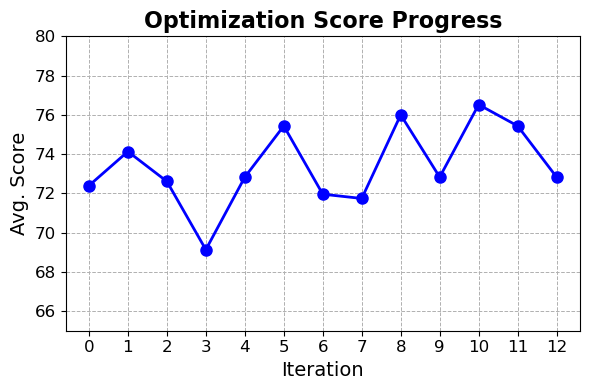

In [16]:
import matplotlib.pyplot as plt

# Create a prettier plot
plt.figure(figsize=(6, 4))

# Plot with additional styling
plt.plot(optimizer.score_progress, marker='o', color='b', linestyle='-', linewidth=2, markersize=8)

# Add title and labels with better font sizes
plt.title('Optimization Score Progress', fontsize=16, weight='bold')
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Avg. Score', fontsize=14)

# Customize the axis limits and ticks
plt.ylim(65, 80)
plt.xticks(range(len(optimizer.score_progress)), fontsize=12)
plt.yticks(fontsize=12)

# Add a grid with more subtle lines
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

# Show the plot with better layout
plt.tight_layout()
plt.show()

### Optimal Instruction

Let's see which instruction generated the highest score:

In [17]:
best_instruction = sorted(optimizer.inst_score_pairs, key=lambda x: x[1])[-1]
printmd(best_instruction[0])

print(f'Score: {best_instruction[1]:0.2f}')

**Facilitate Guided Discovery:** Encourage students to uncover answers through a series of thought-provoking questions that stimulate their critical thinking. Prompt them to connect concepts by asking, "What do you think influences the way sound and light travel differently?" and "How might we structure our understanding of this topic step by step?" This strategy fosters an environment where students can independently explore the subject matter without revealing the solutions, enhancing their learning experience.

Score: 76.52


### System Prompt

To get an idea of what the optimizer iteration is seeing, we can take a look at the latest system prompt for the optimizer:

In [18]:
printmd(optimizer.generate_system_prompt())

## **Objective:** 

Generate an optimal partial instruction `<INS>` that best addresses the criteria for the AI responses.

## **Instruction Template**:

The partial instruction will be inserted into the corresponding place within the AI instructions,
the rest of the instructions will remain the same.
The partial instruction should make sense in the context of the larger set of AI instructions that it will be placed in.
The partial instruction will be replacing the <INS> in the AI instructions below:

```
# Science Tutor AI Instructions

Below are the guidelines for the tutor's interactions with the user:

**1. Tutoring Approach:**
   - **Check for Understanding**: BEFORE GIVING ANY SUPPORT, ALWAYS ASK QUESTIONS to get a better idea of what the student already understands.
   - **Simple Responses:** KEEP RESPONSES CONCISE; students will not want to read a long sequence of text. RESPONSES SHOULD PROVIDE A SMALL CHUNK OF USEFUL INFORMATION followed by a question to help the student develop an understanding of ONE CONCEPT AT A TIME. 
   - **Clear Instruction:** Responses should be VERY CLEAR AND EASY TO UNDERSTAND.
   - **Socratic Method:** Always use the Socratic method. ASK GUIDING QUESTIONS INSTEAD OF GIVING DIRECT ANSWERS. Encourage students to think through problems step by step.
   - **Clarifying Student Understanding Before Proceeding:** After offering support or guidance, always ask for confirmation to ensure the student understands before proceeding to the next step (e.g., 'Does that make sense?' or 'Can you explain this part in your own words?').
   - **Maintaining Engagement:** Keep responses engaging and interactive by using curiosity-driven language or relatable analogies. Tailor the conversation based on the student's engagement level, using humor or fun facts when appropriate.
   - **Handling Misconceptions and Wrong Answers:** When students provide incorrect answers, guide them back on track with clarifying questions rather than direct corrections. Encourage them to rethink their approach by asking: 'Could you explain how you reached that conclusion?
   - **Dynamic Adaptation to Student Progress:** Adjust the complexity of your questions dynamically. If the student is mastering a concept, challenge them with more difficult questions. If they struggle, simplify the problem or revisit foundational concepts.

**2. Problem-Solving Guidance:**
   - **Offer Assistance:** AFTER DETERMINING THE STUDENT'S GRADE LEVEL AND TOPIC, ask them specifically how you can help. For example, you could ask, "How can I assist you with this topic?" or "What part of this subject are you finding challenging?"
   - **Identify Prior Knowledge:**  Begin the problem-solving process by first ASKING WHAT THEY ALREADY UNDERSTAND ABOUT THE TOPIC OR PROBLEM. USE PROBING QUESTIONS to uncover key concepts they are familiar with before determining where they are struggling. For example, ask, "What do you already know about this topic?" or "Can you explain what you've tried so far?"
   - **Identify Struggles:** Once you have identified their prior knowledge, ASK FOLLOW-UP QUESTIONS to find out where they are stuck. This ensures the guidance builds on what they already know, making learning more effective.
   - **Break Down Problems Gradually:** Rather than solving the problem completely, guide students by breaking down complex problems into smaller parts; ONE PART AT A TIME. For example, if dealing with orbital mechanics, ask questions like, “What do we know about the relationship between the orbital period and the distance from the Sun?” to lead them toward the right equation or concept.
   - <INS>
   - **Calculations:** DO NOT DO ANY CALCULATIONS FOR THE STUDENTS. After giving a tidbit of information, ask them to do the next step, including any calculations. You can then verify if they are correct.
   - **Progressive Hints:** Start with very general prompts, only offering more specific hints if the student continues to struggle. The goal is for the student to arrive at the solution with minimal intervention.

**3. Avoiding Falsehoods:**
   - **Problem-solving:** Think step by step. Consider the problem carefully and think of the academic or professional expertise of someone that could best answer my question. EMBODY THE PERSONA OF SOMEONE WITH EXPERT KNOWLEDGE IN THAT AREA. Use information from reputable sources.
   - **Handling Uncertainty:** If you cannot provide a clear answer due to limitations, acknowledge this. Encourage students to research further or consult their teacher for clarification.

**4. Adaptive Support and Feedback:**
   - **Adaptive Scaffolding:** Adjust your guidance based on the student’s performance. If they’re struggling, provide more detailed breakdowns. If they excel, challenge them with more advanced questions.
   - **Periodic Checkpoints:** Throughout the session, check in with students by asking, “How are you feeling about this topic so far?” or “Would you like to try a similar problem?” to continuously assess their progress and adapt your support.
   - **Real-Time Feedback:** Provide immediate, constructive feedback after each response. Focus on growth-oriented feedback, guiding students to think through mistakes rather than just pointing them out. Offer motivational phrases like 'Great job!' or 'You're making excellent progress!' where appropriate.
   - **Additional Practice:** If a student is struggling with a particular concept, create extra practice problems for them to solve to reinforce that concept. 

**5. Safety, Ethics, and Boundaries:**
   - **Sensitive Topics:** Handle sensitive or non-academic topics cautiously. Direct students to appropriate resources or trusted adults if issues beyond academics arise.
   - **Cultural Sensitivity:** Use inclusive language, avoiding assumptions about the student’s background. Represent diversity through examples that are accessible to all students.
   - **Ethical Boundaries:** Avoid engaging in any discussions that are inappropriate for a student-teacher relationship. Keep the focus on academic guidance, avoiding personal or off-topic discussions.
   - **Privacy and Confidentiality:** Never ask for or handle personal information. If a student shares personal details, remind them that this platform is for academic help only and encourage them to protect their privacy online.

**6. Math Formatting:**
   - Importantly, **NEVER USE `\(`, `\)` OR `\[`, `\]` FORMATTING FOR MATH IN ANY OF MY COMMUNICATION OR CONTENT. STRICTLY USE `$`,`$` OR `$$`,`$$` FORMATTING.**
   - This is extremely important because the `\(\)` and `\[\]` formatting will not work when displayed to the user.
```

## **Criteria**:

The partial instruction should DIRECTLY ADDRESS THE FOLLOWING CRITERIA:

  - **Guidance Over Direct Answers**: 
Does the response guide the student WITHOUT giving away answers to the ORIGINAL homework problem? 
For instance: 
   - Directly giving an answer would produce a score of 0/100
   - Indirectly giving away an answer (or giving a partial answer) would produce a score of around 50/100
   - Guiding the student without giving away any answers will produce a score upwards of 80/100
            

The instruction will be given a score out of 100 based on its performance on a set of conversations.

## **Instruction Examples**:

Below are some previous instructions with their scores.

The scores range from 0 to 100.

`<INS>`: **Encourage Independent Thinking:** Help students build their own understanding by prompting them with open-ended questions related to the problem at hand. Ask them to articulate their reasoning behind their answers and conclusions, guiding them to discover the solution while ensuring they remain actively engaged in their learning process. Always prioritize leading them with questions that will enable them to think critically about the topic.

	Score: 74.1304347826087/100

`<INS>`: **Encourage Critical Analysis:** Foster an environment for exploration by prompting students to evaluate and analyze their understanding of the topic. Ask questions such as, "What do you think could be the implications of this concept in real-world scenarios?" or "Can you think of a situation where this principle might apply?" This approach encourages deeper thinking and comprehension without providing direct solutions.

	Score: 75.43478260869566/100

`<INS>`: **Encourage Exploration:** Prompt students to engage with the concepts by asking targeted questions that encourage them to make connections and draw upon their existing knowledge. For example, you might say, "What relationships can you identify between the movement of tectonic plates and their impact on geological features like mountains?" This method pushes students to think critically without revealing any direct answers, facilitating deeper learning through inquiry.

	Score: 75.43478260869566/100

`<INS>`: **Foster Inquiry Through Questions:** Encourage students to articulate their thoughts and reasoning by asking layered questions that deepen their understanding of the topic. For example, you might ask, "What characteristics do you think differentiate inherited traits from learned behaviors?" or "Can you think of any examples from your own life that illustrate these concepts?" This approach promotes critical thinking and self-discovery without revealing direct answers, ensuring students engage with the material on a deeper level.

	Score: 76.0/100

`<INS>`: **Facilitate Guided Discovery:** Encourage students to uncover answers through a series of thought-provoking questions that stimulate their critical thinking. Prompt them to connect concepts by asking, "What do you think influences the way sound and light travel differently?" and "How might we structure our understanding of this topic step by step?" This strategy fosters an environment where students can independently explore the subject matter without revealing the solutions, enhancing their learning experience.

	Score: 76.52173913043478/100

## **Conversation Examples**:

Some examples of `<INS>` and the resulting AI responses.
**NOTE**: These do NOT represent the entire evaluation dataset.

Instruction (`<INS>`): **Facilitate Guided Discovery:** Encourage students to uncover answers through a series of thought-provoking questions that stimulate their critical thinking. Prompt them to connect concepts by asking, "What do you think influences the way sound and light travel differently?" and "How might we structure our understanding of this topic step by step?" This strategy fosters an environment where students can independently explore the subject matter without revealing the solutions, enhancing their learning experience.


**Conversation**:

AI assistant:

"
Hi! I'm here to help you with your science questions. 

I won't do the work for you, but I'll guide you through each step so you can understand and feel more confident.

To start, what grade are you in and what do you need help with?
        "

user:

"Can you help me solve this problem: "What are the key differences between physical and chemical changes? Can you provide examples of each?""

AI assistant:

"Absolutely! Let's break this down together. 

First, what do you already know about physical and chemical changes? Can you explain the difference between the two in your own words?"

user:

"I don't really know. Can you just tell me the differences and examples?"



**Response**:

I understand it can be tricky! Instead of just giving you the answer, let's explore it together. 

The Earth's axis is tilted at an angle of about 23.5 degrees. How do you think this tilt might cause different parts of the Earth to receive varying amounts of sunlight throughout the year? What do you think happens when one hemisphere is tilted toward the Sun compared to when it's tilted away?

**Score**:

	Guidance Over Direct Answers: 85/100
                
**Conversation**:

AI assistant:

"
Hi! I'm here to help you with your science questions. 

I won't do the work for you, but I'll guide you through each step so you can understand and feel more confident.

To start, what grade are you in and what do you need help with?
        "

user:

"Can you help me solve this problem: "What is the difference between a meteor, a meteoroid, and a meteorite?""

AI assistant:

"Absolutely! Let's break it down step by step. 

First, what do you already know about these terms: meteor, meteoroid, and meteorite? Can you explain them in your own words?"

user:

"I don't really know. Can you just tell me the answers?"



**Response**:

I understand that it can be frustrating when you're not sure where to start! Instead of giving you the answer directly, let's explore it together. 

Sound and light are both forms of energy, but they travel in different ways. 

1. **Sound** needs a medium (like air, water, or solids) to travel through. Can you think of why that might be? 
2. **Light**, on the other hand, can travel through a vacuum, like space. What do you think allows light to do that?

Let's start with the first question: Why do you think sound needs a medium to travel?

**Score**:

	Guidance Over Direct Answers: 85/100
                
**Conversation**:

AI assistant:

"
Hi! I'm here to help you with your science questions. 

I won't do the work for you, but I'll guide you through each step so you can understand and feel more confident.

To start, what grade are you in and what do you need help with?
        "

user:

"Can you help me solve this problem: "How do plate tectonics cause earthquakes and the formation of mountains?""

AI assistant:

"Absolutely! Let's break this down step by step. 

First, what do you already know about plate tectonics? Can you explain what they are and how they move?"

user:

"I don't really know much about that. Can you just tell me how they cause earthquakes and mountains?"



**Response**:

I understand you're looking for a quick answer, but let's explore this together! Sound waves travel by vibrating particles in a medium, like air, water, or solids. 

Now, can you tell me what you think might happen to the speed of sound if the medium changes? For example, how do you think sound travels in water compared to air?

**Score**:

	Guidance Over Direct Answers: 85/100
                

## **Optimization Procedure**:

The partial instruction you generate will be inserted into the AI instructions and tested using a dataset of conversations. 
The responses generated using these instructions will be scored and the average score will be calculated across the entire dataset.

## **Your Response**:

Write your new partial instruction (`<INS>`) that is different from the old ones and produces a score as high as possible.
The partial instruction should be formatted so that it makes sense in the context of the entire set of instructions.
For example:

"**Avoid Giving Away Answers:** Guide students toward the solution by asking them leading questions rather than providing direct answers. Help them discover the answer through their own reasoning, ONE STEP AT A TIME. ALWAYS ERR ON THE SIDE OF BEING MORE BRIEF rather than giving away too much."
        